<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/rock_paper_scissors_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Paper Scissors Convnets


## Import

In [1]:
from sys import path
from keras import layers, models, optimizers, preprocessing
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler

## Dataset

In [2]:
# Dataset - hand images with rock, paper or scissors form
# 1772 for training set, 424 for test set

base_dir = path[0] + "/drive/MyDrive/rock-paper-scissors-dataset/"
train_dir = base_dir + "/train/"
test_dir = base_dir + "/test/"
batch_size = 64

train_gen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    rotation_range=20,
    vertical_flip=True,
    validation_split=0.2,
)

val_gen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_gen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_datagen = train_gen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    color_mode='grayscale',
    shuffle=True,
    class_mode="categorical",
    seed=111,
    subset="training",
    batch_size=batch_size
)

val_datagen = val_gen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    color_mode='grayscale',
    shuffle=False,
    class_mode="categorical",
    seed=111,
    subset="validation",
    batch_size=batch_size
)

test_datagen = test_gen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    color_mode='grayscale',
    shuffle=False,
    class_mode="categorical",
    seed=111,
    batch_size=batch_size
)

Found 1415 images belonging to 3 classes.
Found 353 images belonging to 3 classes.
Found 420 images belonging to 3 classes.


## Model

In [3]:
# MODEL DEFINITION - the model need to predict if an image shows rock, paper, scissors

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 1)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation="relu"))

model.add(layers.Dense(3, activation="softmax"))

model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["acc"],
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

## Training

In [6]:
# CALLBACK - Control iterations and save the best model possible

def update_learning_rate(epoch):
  if (epoch < 25):
    return 1e-3

  else:
    return 1e-4

# Stop iterations regarding to accuracy value
early_stop = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)

# Saving model at each epoch if values are better than the previous ones
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

# Adaptive learning rate
lrate_scheduler = LearningRateScheduler(update_learning_rate)

In [7]:
# TRAINING

epochs = 35
history = model.fit(train_datagen, validation_data=val_datagen, batch_size=batch_size, epochs=epochs, callbacks=[model_checkpoint, lrate_scheduler])

Epoch 1/35
23/23 [==============================] - ETA: 0s - loss: 1.0320 - acc: 0.4601
Epoch 1: val_acc improved from -inf to 0.76487, saving model to best_model.h5
23/23 [==============================] - 7s 317ms/step - loss: 1.0320 - acc: 0.4601 - val_loss: 0.7686 - val_acc: 0.7649 - lr: 0.0010
Epoch 2/35
23/23 [==============================] - ETA: 0s - loss: 0.6461 - acc: 0.7625
Epoch 2: val_acc improved from 0.76487 to 0.84986, saving model to best_model.h5
23/23 [==============================] - 6s 276ms/step - loss: 0.6461 - acc: 0.7625 - val_loss: 0.4969 - val_acc: 0.8499 - lr: 0.0010
Epoch 3/35
22/23 [===========================>..] - ETA: 0s - loss: 0.4166 - acc: 0.8445
Epoch 3: val_acc improved from 0.84986 to 0.92635, saving model to best_model.h5
23/23 [==============================] - 6s 273ms/step - loss: 0.4156 - acc: 0.8445 - val_loss: 0.2376 - val_acc: 0.9263 - lr: 0.0010
Epoch 4/35
23/23 [==============================] - ETA: 0s - loss: 0.3210 - acc: 0.8982
Ep

## Results

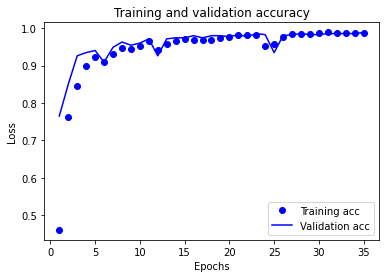

In [8]:
# LOG ACCURACY RESULTS

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, acc_values, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

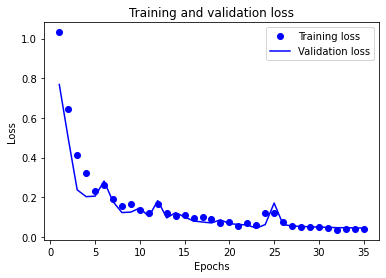

In [9]:
# LOG LOSS RESULTS

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 [==============================] - 2s 210ms/step


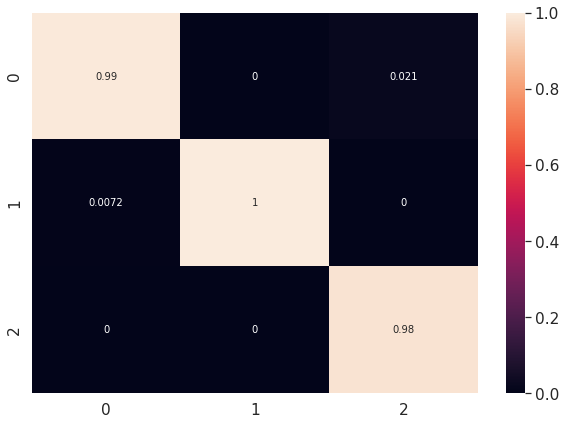

In [10]:
# CONFUSION MATRIX


#Predict
y_prediction = model.predict(test_datagen)
y_prediction = np.argmax (y_prediction, axis = 1)

y_test = test_datagen.labels

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

df_cm = pd.DataFrame(result, range(3), range(3))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size

plt.show()

In [11]:
# EVALUATION

loss, acc = model.evaluate(test_datagen)
print("Accuracy : {}%".format(acc * 100))

7/7 [==============================] - 1s 196ms/step - loss: 0.0324 - acc: 0.9905
Accuracy : 99.04761910438538%
